In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
import sklearn.metrics as metrics
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import r2_score
import sklearn.metrics as metrics

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data shaping functions

In [2]:
def make_dataset(df, train_part, test_part,d_type ="test"):
    X = df.copy(deep=True)
    X.drop(['close_change', 'close'],axis=1, inplace= True)
    if d_type == "test":
        X.drop(X.index[:train_part],inplace= True)
    else : X.drop(X.index[train_part:(train_part+test_part)],inplace= True)
    X = StandardScaler().fit_transform(X)
    return X

In [3]:
def binary_pred(y_pred):
    y_pred_binary = [0]
    for i in range(1, len(y_pred)):
        if y_pred[i] > y_pred[i - 1]:
            y_pred_binary.append(1)
        else:       
            y_pred_binary.append(0)
    return y_pred_binary

## Trading algorithm

In [4]:
def sell(last_deal, revenue, revenue_list, successful_deals, profit, last_price,df,i, train_part):
    last_deal = 1 #продажа
    revenue = revenue + (df['close'][train_part + i] - last_price)*1000
    revenue_list.append(revenue)
    if df['close'][train_part + i] > last_price: #если сделка была успешна
        successful_deals +=1
        profit = profit+(df['close'][train_part + i] - last_price)*1000
    last_price = df['close'][train_part + i]
    return last_deal, revenue, revenue_list, successful_deals, profit, last_price

In [5]:
def buy(last_deal, revenue, revenue_list, successful_deals, profit, last_price,df, i, train_part):
    last_deal = 0
    revenue = revenue + (last_price - df['close'][train_part + i]) *1000
    revenue_list.append(revenue)
    if df['close'][train_part + i] < last_price: #если сделка была успешна
        successful_deals +=1
        profit = profit + (last_price - df['close'][train_part + i])*1000 
    last_price = df['close'][train_part + i]
    return last_deal, revenue, revenue_list, successful_deals, profit, last_price

In [6]:
def trade(df, y_pred, train_part, pred_limit=20,output_class='classification'):
    
    profit = 0
    revenue = 0
    successful_deals = 0
    deals_overall = 0
    actions_list = []
    revenue_list = []
    last_price = 0
    last_deal = 2
    
    if output_class == 'regression':
        y_pred = binary_pred(y_pred)
    
    for i in range(len(y_pred[:pred_limit])):
        pred = y_pred[i] 
        if last_deal == 2:  #смотрим на первое предсказание
            last_price = df['close_change'][train_part + i]
            if pred == 0:  #если ожидаем, что цена пойдет вверх
                last_deal = 1  #последняя сделка - покупка
            else: 
                last_deal = 0
        if (last_deal == 0 and pred == 0): #если есть чем торговать (последняя -покупка) и ожидаем уменьшения цены
            last_deal, revenue, revenue_list, successful_deals, profit, last_price = sell(last_deal, 
                                                                                          revenue, revenue_list, successful_deals, profit, last_price, df, i,train_part)
            actions_list.append(1)
            deals_overall +=1
            continue
        if (last_deal == 1 and pred == 1):
            last_deal, revenue, revenue_list, successful_deals, profit, last_price = buy(last_deal, 
                                                                                         revenue, revenue_list, successful_deals, profit, last_price, df, i, train_part)
            actions_list.append(0)            
            deals_overall +=1
            continue
        actions_list.append(-1)
    return revenue,successful_deals, deals_overall

In [7]:
def train_stat(df, test_part, train_part, best_model, output_class = 'classification'):
    days_plot = []
    revenue_plot = []
    success_plot = []
    deals_overall_plot = []
    for i in range(10, test_part, 10):
        X_train_cycle = make_dataset(df, train_part, i, d_type ="train")
        y_pred_cycle =  best_model.predict(X_train_cycle)
        revenue,successful_deals, deals_overall = trade(df, y_pred_cycle, train_part, i, output_class)
        days_plot.append(i)
        revenue_plot.append(revenue)
        success_plot.append(round(successful_deals*100/i,2))
        deals_overall_plot.append(round(deals_overall*100/i,2))
    
    d = {'days': days_plot, 'revunue': revenue_plot, 'proftitable deals %' : success_plot, 'overall deals %' : deals_overall_plot}
    future = pd.DataFrame(data=d)
    #print(revenue_plot)
    return future

## Metrics

In [8]:
def error_marix(pred_list, true_list):
    TP, FP, FN, TN = 0, 0, 0, 0
    for i in range(len(pred_list)):
        if true_list[i] == 1:
            if pred_list[i] == 1:
                TP +=1
            else: FN +=1
        else:
            if pred_list[i] == 1:
                FP +=1
            else: TN +=1
    print("TP, FP, FN, TN = ", TP, FP, FN, TN)

In [9]:
def classification_metrics_cv(future, X, y):
    tscv = TimeSeriesSplit(n_splits=20)
    accuracy=cross_val_score(model, X, y, cv=tscv, scoring='accuracy')
    precision=cross_val_score(model, X, y, cv=tscv, scoring='precision')
    recall=cross_val_score(model, X, y, cv=tscv, scoring='recall')
    auc_roc= cross_val_score(model, X, y, cv=tscv, scoring='roc_auc')
    print("accuracy", round(accuracy.mean(),4))
    print("precision", round(precision.mean(),4))
    print("recall", round(recall.mean(),4))
    print("AUC-ROC",round(auc_roc.mean(),4))
    print('maximum of profitable deals percentage:', future['proftitable deals %'].max(),"%")

In [10]:
def regression_metrics_cv(future, X, y):
    tscv = TimeSeriesSplit(n_splits=20)
    explained_variance=  cross_val_score(model, X, y, cv=tscv, scoring='explained_variance')
    mean_absolute_error= cross_val_score(model, X, y, cv=tscv,  scoring='neg_mean_absolute_error')
    mse= cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_squared_error')
    median_absolute_error=cross_val_score(model, X, y, cv=tscv, scoring='neg_median_absolute_error')
    r2=cross_val_score(model, X, y, cv=tscv, scoring= 'r2')
    print('explained_variance: ', round(explained_variance.mean(),4))    
    print('r2: ', round(r2.mean(),4))
    print('MAE: ', round(mean_absolute_error.mean(),4))
    print('MSE: ', round(mse.mean(),4))
    print('RMSE: ', round((np.sqrt(mse)).mean(),4))
    print('maximum of profitable deals percentage:', future['proftitable deals %'].max(), "%")

## Data Preparation

In [11]:
df = pd.read_csv('data_ML_25_05.csv', index_col=['date'], parse_dates=['date'], dayfirst=True)
df.head()

,close,close_change,open,high,low,volume,bb_bbh,bb_bbl,bb_bbm,ATR_10,...,ROCI_40,ROCI_60,ROCI_120,Vortex_diff,Vortex_neg,Vortex_pos,ichimoku_a,ichimoku_b,ichimoku_bl,ichimoku_cl
date,,,,,,,,,,,,,,,,,,,,,
2015-01-19,1.15947,1,1.15614,1.16388,1.15514,141004,1.225656,1.149432,1.187544,0.009608,...,0.000000,0.000000,0.000000,-0.412351,0.876489,0.464137,1.175315,1.18409,1.184090,1.166540
2015-06-08,1.12800,1,1.11023,1.13068,1.10842,220017,1.139031,1.079038,1.109034,0.014026,...,5.179729,4.162819,-2.714171,0.011417,0.978159,0.989576,1.113830,1.09936,1.114305,1.113355
2015-06-09,1.12926,1,1.12802,1.13454,1.12140,224134,1.135281,1.081274,1.108277,0.013938,...,4.427676,5.162876,-2.189617,0.071010,0.967493,1.038503,1.113830,1.09936,1.114305,1.113355
2015-06-10,1.13099,1,1.12926,1.13865,1.12600,246733,1.134962,1.081451,1.108207,0.013809,...,4.041175,5.017875,-2.624261,0.027184,0.995233,1.022417,1.113997,1.09936,1.114305,1.113690
2015-06-11,1.12458,0,1.13099,1.13315,1.11820,203152,1.136311,1.081135,1.108723,0.013923,...,3.500069,3.460077,-0.889245,-0.028576,1.015807,0.987231,1.114712,1.09936,1.114305,1.115120


In [12]:
train_part = int(len(df.close)*0.8)
test_part = len(df.close) - train_part

In [13]:
X_test = make_dataset(df, train_part, test_part,d_type ="test")
X_train = make_dataset(df, train_part, test_part,d_type ="train")
y_train = df['close_change'][:-test_part]
y_test = df['close_change'][-test_part:]

In [14]:
tscv = TimeSeriesSplit(n_splits=20)

## Models

In [15]:
LR = LogisticRegression(
    C= 0.75,
    class_weight=None,
    dual= False,
    fit_intercept= True,
    intercept_scaling= 1,
    l1_ratio= None,
    max_iter= 100000,
    multi_class= 'auto',
    n_jobs= None,
    penalty= 'l2',
    random_state= None,
    solver= 'liblinear',
    tol= 0.0001,
    verbose= 0,
    warm_start= False)

In [16]:
SVC = SVC(
    C= 0.75,
    break_ties= False,
    cache_size= 200,
    class_weight= None,
    coef0= 0.0,
    decision_function_shape= 'ovr',
    degree= 3,
    gamma= 'scale',
    kernel= 'linear',
    max_iter= -1,
    probability= True,
    random_state= None,
    shrinking= True,
    tol= 0.001)

In [17]:
RFC = RandomForestClassifier(
     criterion= 'entropy',
     max_depth= 14,
     max_features= 'auto',
     max_leaf_nodes= None,
     max_samples= None,
     min_impurity_decrease= 0.0,
     min_samples_leaf= 1,
     min_samples_split= 2,
     min_weight_fraction_leaf= 0.0,
     n_estimators= 75)

In [18]:
GBC = GradientBoostingClassifier(
    criterion= 'friedman_mse',
    learning_rate=0.5,
    loss= 'exponential',
    max_depth= 3,
    min_impurity_decrease= 0.0,
    min_impurity_split= None,
    min_samples_leaf= 11,
    min_samples_split= 15,
    min_weight_fraction_leaf= 0.0,
    n_estimators= 80,
    presort= 'deprecated',
    subsample= 1.0,
    tol= 0.0001,
    validation_fraction= 0.1)

In [19]:
RFR = RandomForestRegressor(
    bootstrap= True,
    ccp_alpha= 0.0,
    criterion= 'mse',
    max_depth= 4,
    max_features='log2',
    max_leaf_nodes= None,
    max_samples= None,
    min_impurity_decrease= 0.0,
    min_impurity_split= None,
    min_samples_leaf= 1,
    min_samples_split= 2,
    min_weight_fraction_leaf= 0.0,
    n_estimators= 75,)

In [20]:
GBR = GradientBoostingRegressor(alpha= 0.9,
     criterion= 'friedman_mse',
     learning_rate= 0.1,
     loss= 'huber',
     max_depth= 3,
     min_samples_leaf= 3,
     min_samples_split= 15,
     n_estimators= 50,
     presort= 'deprecated')

In [21]:
models = []
models.append(('LR', LR))
models.append(('SVC', SVC)) 
models.append(('GBC', GBC)) 
models.append(('RFC', RFC)) 
models.append(('GBR', GBR)) 
models.append(('RFR', RFR))

In [22]:
names_dict = {'LR' : 'Logistic Regression', 'SVC' : 'Support Vector Classifier', 'GBC' : 'Gradient Boosting Classifier',
         'RFC' :'Random Forest Classifier', 'GBR' : 'Gradient Boosting Regressor', 'RFR' :'Random Forest Regressor'}

## Result


 Logistic Regression


D:\apps\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\apps\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy 0.7353
precision 0.7216
recall 0.4961
AUC-ROC 0.8312
maximum of profitable deals percentage: 40.0 %
TP, FP, FN, TN =  144 34 60 135


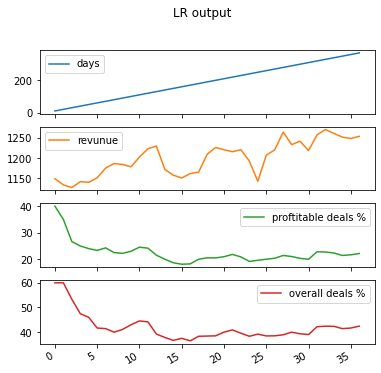


 Support Vector Classifier


D:\apps\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\apps\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy 0.7176
precision 0.844
recall 0.4229
AUC-ROC 0.8566
maximum of profitable deals percentage: 40.0 %
TP, FP, FN, TN =  152 27 52 142


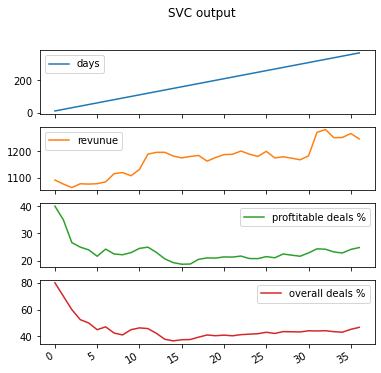


 Gradient Boosting Classifier


D:\apps\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\apps\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy 0.5824
precision 0.5971
recall 0.6671
AUC-ROC 0.6403
maximum of profitable deals percentage: 27.5 %
TP, FP, FN, TN =  140 61 64 108


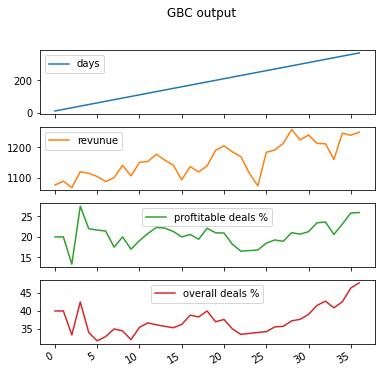


 Random Forest Classifier

 Gradient Boosting Regressor
explained_variance:  0.3807
r2:  0.2028
MAE:  -0.061
MSE:  -0.0061
RMSE:  nan
maximum of profitable deals percentage: 42.86 %


<ipython-input-10-caf8efd6f84e>:12: RuntimeWarning: invalid value encountered in sqrt
  print('RMSE: ', round((np.sqrt(mse)).mean(),4))


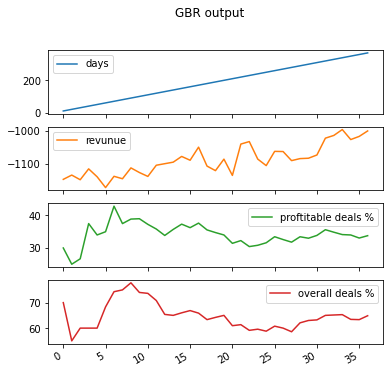


 Random Forest Regressor
explained_variance:  0.4601
r2:  -0.0322
MAE:  -0.0314
MSE:  -0.0016
RMSE:  nan
maximum of profitable deals percentage: 35.0 %


<ipython-input-10-caf8efd6f84e>:12: RuntimeWarning: invalid value encountered in sqrt
  print('RMSE: ', round((np.sqrt(mse)).mean(),4))


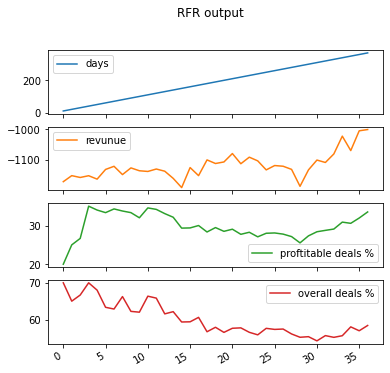

ValueError: Dimensions of labels and X must be compatible

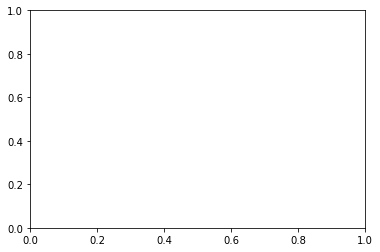

In [25]:
results_regression = []
results_classification = []
names = []

for name, model in models:
    # TimeSeries Cross validation
    print("\n",names_dict[name])
    tscv = TimeSeriesSplit(n_splits=20)
    model.fit(X_train, y_train)

    if name == "RFC" : 
        cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='accuracy')
        results_classification.append(cv_results)
        continue
    if name == "GBR" or name == "RFR":
        cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
        results_regression.append(cv_results)
        future = train_stat(df, test_part, train_part, model,output_class='regression')
        y_pred = model.predict(X_test) 
        regression_metrics_cv(future, X_test, y_pred)
    else:
        cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='accuracy')
        results_classification.append(cv_results)
        future = train_stat(df, test_part, train_part, model,output_class='classification')
        y_pred = model.predict(X_test) 
        classification_metrics_cv(future, X_test, y_pred)
        error_marix(y_pred, y_test)
        names.append(name)
    plot_title = name + ' output'
    future.plot(subplots=True, figsize=(6, 6), title=plot_title)
    plt.show()

# Compare Algorithms
plt.boxplot(results_classification, labels=names)
plt.title('Classification Algorithms Comparison')
plt.show()